<a href="https://colab.research.google.com/github/chihyanghsu0805/machine_learning/blob/tutorials/tutorials/keras/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook re-implements the tutorial on https://keras.io/examples/vision/image_classification_with_vision_transformer.

The original paper is https://arxiv.org/pdf/2010.11929.pdf.

The orginal code is https://github.com/google-research/vision_transformer.

![](https://github.com/chihyanghsu0805/machine_learning/blob/main/tutorials/keras/images/vit.png?raw=true)



## Install dependencies and Load libraries

In [1]:
pip install -U tensorflow-addons

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## Load Data

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

## Exploratory Data Analysis

In [4]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

num_classes = len(np.unique(y_train))
print(f"Number of Classes: {num_classes}")

input_shape = x_train[0].shape
print(f"Input Shape: {input_shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
Number of Classes: 100
Input Shape: (32, 32, 3)


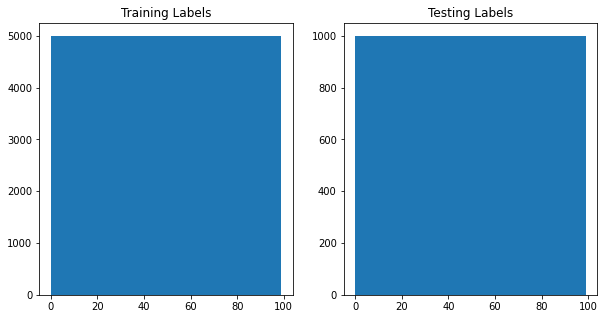

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
_ = plt.hist(y_train)
_ = plt.title("Training Labels")

plt.subplot(1, 2, 2)
_ = plt.hist(y_test)
_ = plt.title("Testing Labels")

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


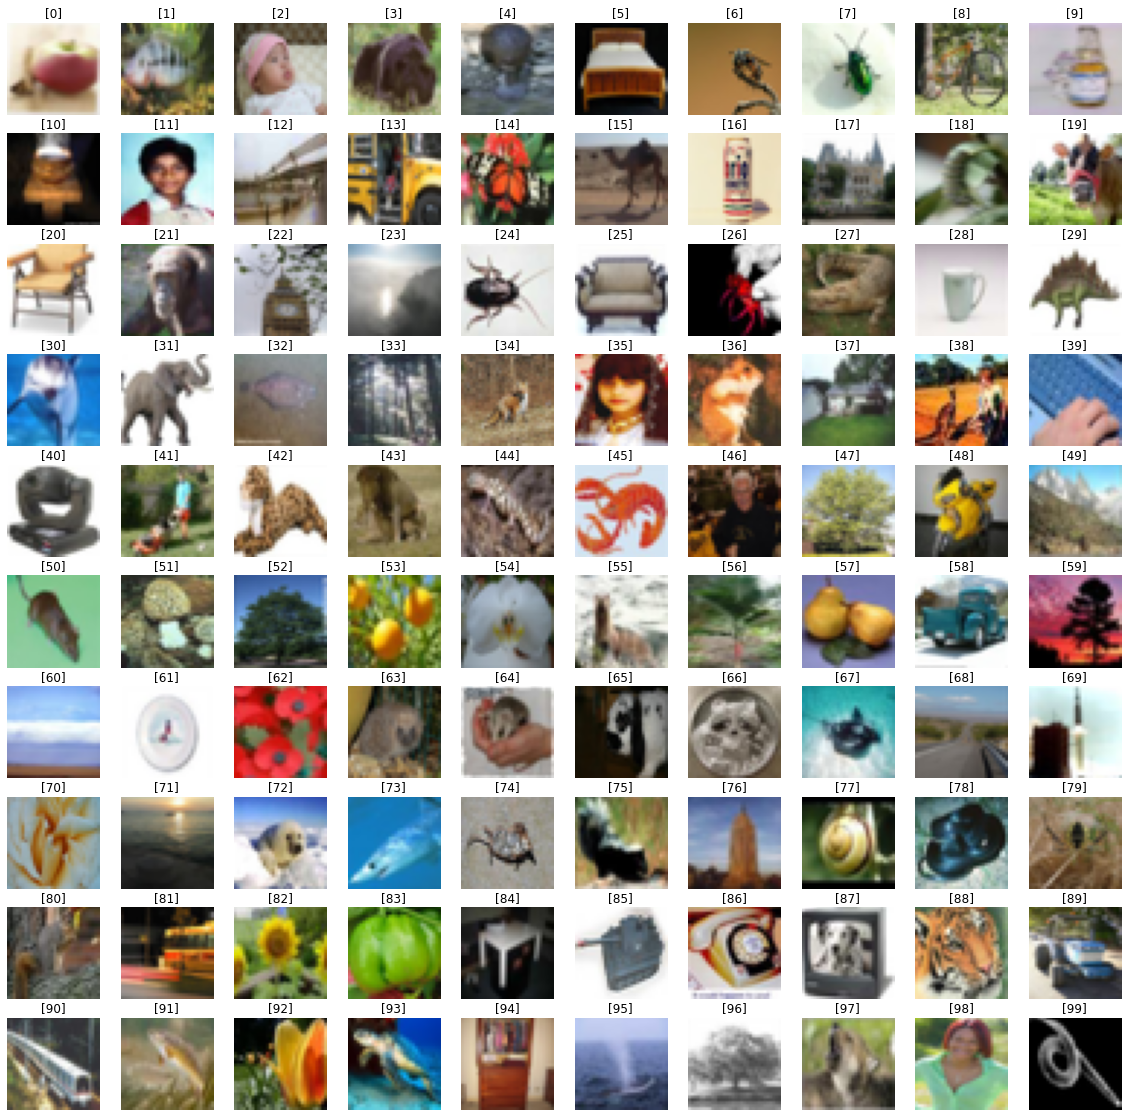

In [6]:
plt.figure(figsize=(20,20))

for i in range(num_classes):

    for x, y in zip(x_train, y_train):

        if y == i:
            plt.subplot(10, 10, i + 1)
            plt.imshow(x)
            plt.title(y)
            plt.axis("off")
            break

## Hyperparameters

In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Data augmentation

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Multilayer perceptron

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Patch creation
To handle 2D images, we reshape the image x ∈ $R^{HxWxC}$ into a sequence of flattened 2D patches $x_p$ ∈ $R^{N×(P^2C)}$, where (H, W) is the resolution of the original image, C is the number of channels, (P, P) is the resolution of each image patch, and N = HW/$P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


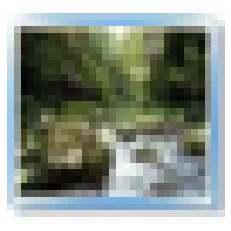

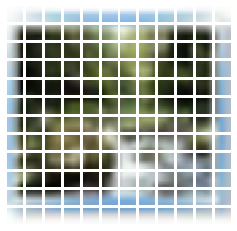

In [11]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}") # 6x6x3

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch encoding = projection + position
The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Position embeddings are added to the patch embeddings to retain positional information.

![](https://github.com/chihyanghsu0805/machine_learning/blob/main/tutorials/keras/images/vit_eq.png?raw=true)

In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## VIT

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

Both during pre-training and fine-tuning, a classification head is attached to z. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Train model

In [14]:
vit_classifier = create_vit_classifier()

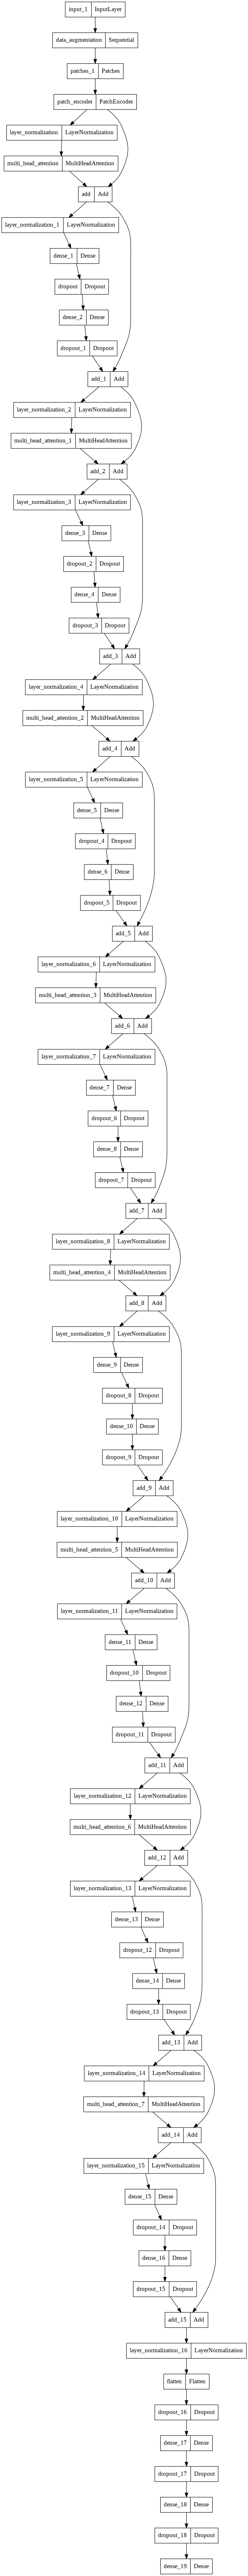

In [15]:
keras.utils.plot_model(
    vit_classifier,
    to_file="./model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

vit_classifier.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = vit_classifier.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[checkpoint_callback],
)

Epoch 1/100
176/176 [==============================] - 78s 385ms/step - loss: 4.4908 - accuracy: 0.0438 - top-5-accuracy: 0.1555 - val_loss: 3.9419 - val_accuracy: 0.0986 - val_top-5-accuracy: 0.2988
Epoch 2/100
176/176 [==============================] - 67s 381ms/step - loss: 3.9525 - accuracy: 0.0896 - top-5-accuracy: 0.2842 - val_loss: 3.6003 - val_accuracy: 0.1526 - val_top-5-accuracy: 0.4082
Epoch 3/100
176/176 [==============================] - 67s 381ms/step - loss: 3.7012 - accuracy: 0.1267 - top-5-accuracy: 0.3608 - val_loss: 3.3621 - val_accuracy: 0.1896 - val_top-5-accuracy: 0.4698
Epoch 4/100
176/176 [==============================] - 68s 386ms/step - loss: 3.5127 - accuracy: 0.1585 - top-5-accuracy: 0.4190 - val_loss: 3.1731 - val_accuracy: 0.2302 - val_top-5-accuracy: 0.5208
Epoch 5/100
 58/176 [========>.....................] - ETA: 43s - loss: 3.3818 - accuracy: 0.1848 - top-5-accuracy: 0.4591

## Evaluate model

In [ ]:
vit_classifier.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

![](https://github.com/chihyanghsu0805/machine_learning/blob/main/tutorials/keras/images/vit_classifier.png?raw=true)